In [1]:
import numpy as np 
import pandas as pd 

In [2]:
class momentumBackTester():
    def __init__(self, asset_name, start, end, transaction_cost = 0, price_col = 'Adj Close'):
        self.asset_name = asset_name
        self.start = start
        self.end = end
        self.price_col = price_col
        self.data = self.data_processor(pd.read_csv(self.asset_name+'.csv', index_col = 0, parse_dates = True).dropna())
        self.marketReturn = self.data.tail(1).values[0] / self.data.head(1).values[0]
        print("Market Return For" +  asset_name + " is " + str(self.marketReturn[0] * 100) + "%")
        # return initialization
        self.data['returns'] = np.log(self.data['price']/self.data['price'].shift(1))              # if p[T + 1] > p[T], return for T > 0

        
    def data_processor(self,raw):
        price_col = self.price_col
        data = pd.DataFrame(raw[price_col])
        data.rename(columns = {price_col: 'price'}, inplace = True)
        
        # date mask
        mask = (data.index > self.start) & (data.index <= self.end)
        data = data.loc[mask]
        return data
    
    def single_test(self,window,plot = True):
        data = self.data
        rollingWindow = window

        data['position'] = np.sign(data['returns'].rolling(rollingWindow).mean())   # if mean of return during rolling window > 0, 
                                                                                    # position has positive sign ( = 1.0)

        data['strat'] = data['position'].shift(1) * data['returns']                 # strat = sign * return 
        
        df = data[['returns', 'strat']].dropna().cumsum().apply(np.exp)
        return_strategy = df.tail(1).values[0][1]
        print("Return for strategy (rolling window = %d): %s" %(window, format(return_strategy* 100 - 100, ".2f")) +"%")
        
        if plot:
            df.plot(title = self.asset_name + ' Return and Strategy Return, rolling window = ' + str(window), figsize=(10, 6))
        
    def multiple_test(self, min, max, step,plot = True):
        data = self.data
        plot_col = ['returns']

        strat_cnt = 0
        line_style = ['-']
        for w in range(min,max,step):
            data['position_%d' % w] = np.sign(data['returns'].rolling(w).mean())   
            data['strat_%d' % w] = data['position_%d' % w].shift(1) * data['returns']                 # strat = sign * return          
            plot_col.append('strat_%d' % w)
            strat_cnt += 1
            line_style.append('--')
        
        df = data[plot_col].dropna().cumsum().apply(np.exp)
        
        #print function
        for w in range(min,max,step):
            return_strategy = df['strat_%d' % w].tail(1).values[0]
            print("Return for strategy (rolling window = %d): %s" %(w,format(return_strategy* 100 - 100, ".2f") ) + "%")
            
        if plot:
            df.plot(title = 'TSLA Return and Strategies Comparison', 
                                                                        figsize=(16, 9), style = line_style)

    def outputReturn(self):
        pass

In [3]:
# initialization: input parameter: name(.csv), startDate, endDate.
engine = momentumBackTester('TSLA', '6/15/2017' , '6/15/2022')

Market Return ForTSLA is 941.0339383553303%


Return for strategy (rolling window = 1): 0.68%
Return for strategy (rolling window = 3): 246.14%


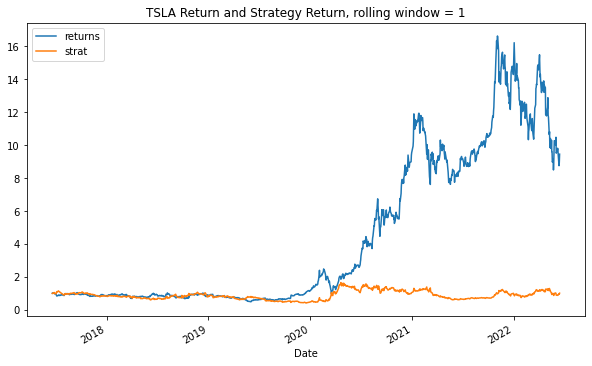

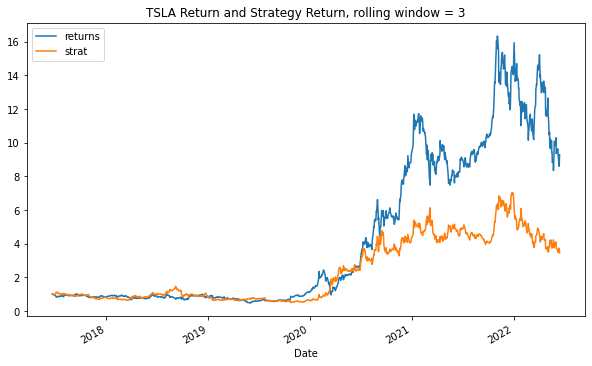

In [4]:
# test a single rolling window, e.g 1 day, 3 day mean
engine.single_test(1)
#engine.single_test(3)

In [ ]:
# test multiple rolling window at the same time. Input: min, max, step (as in python range function)
engine.multiple_test(1,100,10)